In [47]:
from numpy import linalg as LA
import numpy as np
from numpy import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

QUIET    = 0;
MAX_ITER = 500;
ABSTOL   = 1e-6;
RELTOL   = 1e-5;
MU = 10
tau_incr = 2
tau_decr = 2

#class for storing error norms for graphs later:
class record:
    r_norm = []
    s_norm1 = []
    s_norm2 = []
    objval_x = []
    objval_z = []
    eps_pri = []
    eps_dual = []
    z_record = []
    xyratio = []
    sigma_record = []
    
    def __init__(self, n):
        self.r_norm = np.zeros(n)
        self.s_norm1 = np.zeros(n)
        self.s_norm2 = np.zeros(n)
        self.objval_x = np.zeros(n)
        self.objval_z = np.zeros(n)
        self.eps_pri = np.zeros(n)
        self.eps_dual = np.zeros(n)
        self.z_record = np.zeros((n,3))
        self.xyratio = np.zeros(n)
        self.sigma_record = np.zeros((n,2))
        
        
def projection_2D(x, mu = 1):
    if LA.norm(x) == 0:
        return x
    if abs(x[0]) <= mu*x[1]:
        #inside the cone
        return x
    elif abs(x[0]) <= -x[1]/mu:
        #inside polar cone
        return np.zeros(2)
    else:
        #project to the xyplane:
        t_hat = x[0:1]
        #normalize:
        t_hat = t_hat/LA.norm(t_hat)
        unit = np.append(mu*t_hat, 1)
        unit= unit/np.sqrt(1+mu**2)
        #now project to the ray:
        return np.inner(unit, x)*unit   

    

#qp with ADMM customized for physical problem
# M: mass matrix, J: geomety matrix to get relative velocity 
# R: should be passed into as a vector since it is diagonal 
def quadprog_conic(vn, sigman, M, J, R, vstar, vhat, rho, alpha, mustartilda = 1, mu = 1):
    n1 = J.shape[0]
    n2 = R.shape[0]
    n3 = M.shape[0]
    v = vn
    sigma = projection_2D(-1/R*(J.dot(v) -vhat), mu)
    #sigma = np.zeros(n2)
    z = J.dot(v) - vhat + R*sigma
    ztilda = 1/(np.sqrt(R))*z
    utilda = -np.sqrt(R)*sigma/rho
    num_iter = 0
    history = record(MAX_ITER)
    rho_new = rho
    L = zeros((n3,n3))
    #print('initial check')
    #print(LA.norm(R*(sigma+rho*(np.sqrt(R)*utilda))))
    
    for k in range(MAX_ITER):
        if rho_new != rho or k == 0:
            rho = rho_new
            L = LA.cholesky(M + rho/(1+rho)*np.matmul(np.transpose(J), np.matmul(np.diag(1/R), J)))
            rsigma = rho*np.sqrt(R)*(ztilda - utilda + 1/(np.sqrt(R))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - rho/(1+rho)*np.transpose(J).dot(1/R*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/(1+rho)*(1/R* (rsigma - rho*J.dot(v)))
        else:
            rsigma = rho*np.sqrt(R)*(ztilda - utilda + 1/(np.sqrt(R))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - rho/(1+rho)*np.transpose(J).dot(1/R*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/(1+rho)*(1/R* (rsigma - rho*J.dot(v)))
        
        #z-update with relaxation
        ztildaold = ztilda
        #x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        #z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        ztilda = projection_2D(1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma + utilda - 1/(np.sqrt(R))*vhat, mustartilda)
        
        utilda = utilda + 1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma - ztilda - 1/(np.sqrt(R))*vhat
        
        #three stopping criteria:
        #1. check r:
        
        history.r_norm[k] = LA.norm(np.sqrt(R)*(1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma - ztilda - 1/(np.sqrt(R))*vhat))
        history.s_norm1[k] = LA.norm(R*sigma+rho*(np.sqrt(R)*utilda))
        tauc = np.transpose(J).dot(sigma)
        P = M.dot(v)
        rm = M.dot(v - vstar)-tauc
        history.s_norm2[k] = LA.norm(rm)/np.maximum(LA.norm(P), LA.norm(tauc))
        history.xyratio[k] = abs(sigma[0]/sigma[1])
        history.sigma_record[k,:] = sigma

        history.eps_pri[k] = ABSTOL + RELTOL*np.maximum(LA.norm(J.dot(v)), LA.norm(vhat))
        #update rho if two norms are very different:
        #if history.r_norm[k] > MU*history.s_norm[k] and rho < 10000:
            #rho_new = rho*tau_incr
            #utilda = utilda/tau_incr
        #if history.s_norm[k] > MU*history.r_norm[k] and rho < 10000:
            #rho_new = rho/tau_decr
            #utilda = utilda*tau_decr
        if k > 100:
            print(history.r_norm[k])
            print(history.s_norm1[k])
            print(history.s_norm2[k])
            print(history.xyratio[k])
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm1[k] < history.eps_pri[k] and history.s_norm2[k] < ABSTOL):#and history.xyratio[k] < mu):
            #print('hit here')
            #print('xyratio:')
            #print(history.xyratio[k])
            #print('mu')
            #print(mu)
            num_iter = k+1
            break
    if num_iter == 0:
        print('used all iterations with rho:')
        print(rho)
    
    return v,sigma, history, num_iter


def quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, mustartilda = 1, mu = 1):
    n1 = J.shape[0]
    n2 = R.shape[0]
    n3 = M.shape[0]
    v = vn
    sigma = projection_2D(-1/R*(J.dot(v) -vhat), mu)
    #sigma = np.zeros(n2)
    z = J.dot(v) - vhat + R*sigma
    ztilda = 1/(np.sqrt(D))*z
    utilda = -np.sqrt(D)*sigma/rho
    num_iter = 0
    history = record(MAX_ITER)
    rho_new = rho
    L = zeros((n3,n3))
    #print('initial check')
    #print(LA.norm(R*(sigma+rho*(np.sqrt(R)*utilda))))
    
    B = M+rho*np.matmul(np.transpose(J), np.matmul(np.diag(1/D), J))
    C = rho*np.matmul(np.diag(R*1/D), J)
    E = R + rho*R*R*1/D #E is still vector!!
    
    for k in range(MAX_ITER):
        if rho_new != rho or k == 0:
            rho = rho_new
            L = LA.cholesky(B - np.matmul(np.transpose(C), np.matmul(np.diag(1/E), C)))
            rsigma = rho*R*1/(np.sqrt(D))*(ztilda - utilda + 1/(np.sqrt(D))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - np.transpose(C).dot(1/E*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/E*(rsigma - C.dot(v))
        else:
            rsigma = rho*R*1/(np.sqrt(D))*(ztilda - utilda + 1/(np.sqrt(D))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - np.transpose(C).dot(1/E*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/E*(rsigma - C.dot(v))
        
        #z-update with relaxation
        ztildaold = ztilda
        #x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        #z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        ztilda = projection_2D(1/(np.sqrt(D))*J.dot(v)+ 1/(np.sqrt(D))*R*sigma + utilda - 1/(np.sqrt(D))*vhat, mustartilda)
        
        utilda = utilda + 1/(np.sqrt(D))*J.dot(v)+ 1/(np.sqrt(D))*R*sigma - ztilda - 1/(np.sqrt(D))*vhat
        
        #three stopping criteria:
        #1. check r:
        
        history.r_norm[k] = LA.norm(np.sqrt(D)*(1/(np.sqrt(D))*J.dot(v)+1/(np.sqrt(D))*R*sigma - ztilda - 1/(np.sqrt(D))*vhat))
        history.s_norm1[k] = LA.norm(R*sigma+rho*R*(1/np.sqrt(D)*utilda))
        tauc = np.transpose(J).dot(sigma)
        P = M.dot(v)
        rm = M.dot(v - vstar)-tauc
        history.s_norm2[k] = LA.norm(rm)/np.maximum(LA.norm(P), LA.norm(tauc))
        history.xyratio[k] = abs(sigma[0]/sigma[1])
        history.sigma_record[k,:] = sigma

        history.eps_pri[k] = ABSTOL + RELTOL*np.maximum(LA.norm(J.dot(v)), LA.norm(vhat))
        #update rho if two norms are very different:
        #if history.r_norm[k] > MU*history.s_norm[k] and rho < 10000:
            #rho_new = rho*tau_incr
            #utilda = utilda/tau_incr
        #if history.s_norm[k] > MU*history.r_norm[k] and rho < 10000:
            #rho_new = rho/tau_decr
            #utilda = utilda*tau_decr
        if k > 100:
            print(history.r_norm[k])
            print(history.s_norm1[k])
            print(history.s_norm2[k])
            #print(history.xyratio[k])
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm1[k] < history.eps_pri[k] and history.s_norm2[k] < ABSTOL):#and history.xyratio[k] < mu):
            #print('hit here')
            #print('xyratio:')
            #print(history.xyratio[k])
            #print('mu')
            #print(mu)
            num_iter = k+1
            break
    if num_iter == 0:
        print('used all iterations with rho:')
        print(rho)
    
    return v,sigma, history, num_iter

def quadprog_conic_noinitialization(vn, sigman, M, J, R, vstar, vhat, rho, alpha, mu = 1):
    n1 = J.shape[0]
    n2 = R.shape[0]
    n3 = M.shape[0]
    v = vn
    sigma = projection_2D(-1/R*(J.dot(v) -vhat), mu)
    #x = np.zeros(n)
    z = J.dot(v) - vhat + R*sigma
    ztilda = 1/(np.sqrt(R))*z
    utilda = -1/np.sqrt(R)*sigma/rho
    num_iter = 0
    history = record(MAX_ITER)
    rho_new = rho
    L = zeros((n3,n3))
    
    for k in range(MAX_ITER):
        if rho_new != rho or k == 0:
            rho = rho_new
            L = LA.cholesky(M + rho/(1+rho)*np.matmul(np.transpose(J), np.matmul(np.diag(1/R), J)))
            rsigma = rho*np.sqrt(R)*(ztilda - utilda + 1/(np.sqrt(R))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - rho/(1+rho)*np.transpose(J).dot(1/R*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/(1+rho)*(1/R* (rsigma - rho*J.dot(v)))
        else:
            rsigma = rho*np.sqrt(R)*(ztilda - utilda + 1/(np.sqrt(R))*vhat)
            rv = np.transpose(J).dot((1/R*rsigma)) + M.dot(vstar)
            rhs = rv - rho/(1+rho)*np.transpose(J).dot(1/R*rsigma)
            v = LA.solve(np.transpose(L), rhs)
            v = LA.solve(L, v)
            sigma = 1/(1+rho)*(1/R* (rsigma - rho*J.dot(v)))
        
        #z-update with relaxation
        ztildaold = ztilda
        #x_hat = alpha*x + (1-alpha)*zold
        
        #projection to the cone:
        #z = np.minimum(ub, np.maximum(lb, x_hat+u))
        #3D projection (uncomment for conic constraints and comment line above for conic constraints):
        ztilda = projection_2D(1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma + utilda - 1/(np.sqrt(R))*vhat, mu)
        
        utilda = utilda + 1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma - ztilda - 1/(np.sqrt(R))*vhat

        history.r_norm[k] = LA.norm(1/(np.sqrt(R))*J.dot(v)+np.sqrt(R)*sigma - ztilda - 1/(np.sqrt(R))*vhat)
        #TODO: rewrite the part below this line
        history.s_norm[k] = LA.norm(rho*(ztilda-ztildaold))
        history.eps_pri[k] = np.sqrt(n1+n2)*ABSTOL + RELTOL*np.maximum(np.sqrt(LA.norm(v)**2+ LA.norm(sigma)**2), LA.norm(-ztilda))
        history.eps_dual[k] = np.sqrt(n1+n2)*ABSTOL + RELTOL*LA.norm(rho*utilda) 
        #update rho if two norms are very different:
        if history.r_norm[k] > MU*history.s_norm[k] and rho < 10000:
            rho_new = rho*tau_incr
            utilda = utilda/tau_incr
        if history.s_norm[k] > MU*history.r_norm[k] and rho < 10000:
            rho_new = rho/tau_decr
            utilda = utilda*tau_decr
        #stopping criterion:
        if (history.r_norm[k] < history.eps_pri[k] and history.s_norm[k] < history.eps_dual[k]):
            #print('hit here')
            num_iter = k+1
            break
    if num_iter == 0:
        print('used all iterations with rho:')
        print(rho)
    
    return v,sigma, history, num_iter

In [85]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
from numpy.linalg import inv
from matplotlib.pyplot import figure

#Dropping Particel Code:

def dropping_particle(time = 2, dt = 0.1, tau_d = 0, pos_start = np.array([1,0]), vel_start = np.array([0,0]), test = False):
    
    rho = 1
    alpha = 1
    #tau_d = 1
    m = 1
    mu = 0.5
    g = np.array([0, -10])
    F = np.array([6,0]) #applied force in Newtons
    epsilon = 0.001
    M = m*np.identity(2)
    J = np.identity(2)
    #dt = 0.01
    k = 1000
    Rn = 1/(dt*(dt+tau_d)*k)
    Rt = epsilon*Rn
    R = np.array([Rt, Rn])

    #quantities needed for optimization:
    q0 = pos_start
    v0 = vel_start
    sigma0 = np.array([0, 0])

    vhat = np.array([0, -q0[1]/(dt+tau_d)])

    #time = 5
    steps = int(time/dt)

    q = q0
    v = v0
    sigma = sigma0
    positions_record = np.zeros((steps, 2))
    velocities_record = np.zeros((steps,2))
    force_record = np.zeros((steps,2))
    num_iters = np.zeros(steps)
    epsilon_record = np.zeros(steps)
    r_norm_record = np.zeros(steps)
    s_norm1_record = np.zeros(steps)
    verbose = [True, True]
    if test:
        steps = 1
    for i in range(steps):

        vhat[1] = -q[1]/(dt+tau_d)
        vstar = v + dt*g + F/m*dt
        vn = v
        sigman = sigma
        #v,sigma, history, num_iter = quadprog_conic(vn, sigman, M, J, R, vstar, vhat, rho, alpha, np.sqrt(Rn/Rt)*1/mu, mu)
        
        WM = np.matmul(np.transpose(J), np.matmul(inv(M), J))
        D = diag(WM)
        #D = np.sqrt(diag(WM)*R)
        v,sigma, history, num_iter = quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, np.sqrt(D[1]/D[0])*1/mu, mu)
        
        #D = R 
        #v,sigma, history, num_iter = quadprog_conic_general(vn, sigman, M, J, R, D, vstar, vhat, rho, alpha, np.sqrt(D[1]/D[0])*1/mu, mu)
        
        r_norm_record[i] = history.r_norm[num_iter-1]
        s_norm1_record[i] = history.s_norm1[num_iter-1]
        if test: 
            figure()
            #t = np.arange(0, num_iter, 1)    

            print(num_iter)
            plt.plot( history.xyratio[0:num_iter])
            plt.yscale("log")
            plt.title('xyratio')
            plt.show()
            print(history.xyratio[0:40])

            plt.plot( np.absolute(history.sigma_record[0:num_iter, 0]))
            plt.yscale("log")
            plt.title('xforce')
            plt.show()
            plt.plot( history.sigma_record[0:num_iter, 1])
            plt.yscale("log")
            plt.title('yforce')
            plt.show()
            print('force final')
            print(history.sigma_record[num_iter-1, :])
        
        tauc = np.transpose(J).dot(sigma)
        P = M.dot(v)
        rm = M.dot(v - vstar)-tauc
        epsilonmn = LA.norm(rm)/np.maximum(LA.norm(P), LA.norm(tauc))
        epsilon_record[i] = epsilonmn
        q = q + dt*v
        
        #print(numiter)
        positions_record[i, :] = q
        velocities_record[i, :] = v
        force_record[i, :] = sigma
        num_iters[i] = num_iter
        
        if v[0] < v0[0] and verbose[0] == True:
            print('velocity starts dropping at time')
            print(i*dt)
            verbose[0] = False
        
        if (v[0] < 1e-6) and verbose[1] == True:
            print('velocity drop to 0 at time')
            print(i*dt)
            verbose[1] = False
        
        


    t = np.arange(0, time, dt)    
    plt.plot(t, positions_record[:, 0])
    plt.title('positions on the x direction')
    plt.show()
    figure()
    t = np.arange(0, time, dt)    
    plt.plot(t, positions_record[:, 1])
    plt.title('positions on the y direction')
    plt.show()
    figure()
    plt.plot(t, velocities_record[:, 0])
    plt.title('velocities on the x direction')
    plt.show()
    figure()
    plt.plot(t, velocities_record[:, 1])
    plt.title('velocities on the y direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 0]/dt)
    plt.title('force on the x direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 1]/dt)
    plt.title('force on the y direction')
    plt.show()
    figure()
    plt.plot(t, force_record[:, 0]/force_record[:, 1])
    plt.title('force quotient x/y')
    plt.show()
    figure()
    plt.plot(t, epsilon_record)
    plt.title('epsilonmn')
    plt.show()
    figure()
    plt.plot(t, r_norm_record)
    plt.title('r_norm residual')
    plt.show()
    figure()
    plt.plot(t, s_norm1_record)
    plt.title('s_norm1 residual')
    plt.show()
    figure()
    plt.plot(t, num_iters)
    plt.title('Number of Iterations Taken')
    plt.show()
    #print(velocities_record[0, 1])
    print('x force at time end:')
    print(force_record[-5, 0])
    print('y force at time end:')
    print(force_record[-5,1])
    print('velovity at time 3', velocities_record[int(3/dt)])
    print('R', R)
    print(force_record[0,0]/force_record[0,1])
    print(num_iters[-2])
    print(tau_d)
    print(mu)
    print('lowest displacement on y: ', np.amin(positions_record[:, 1]) )


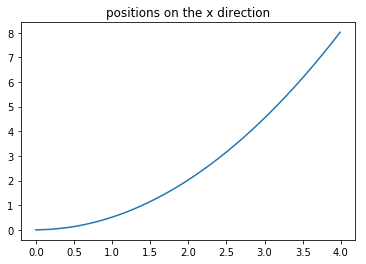

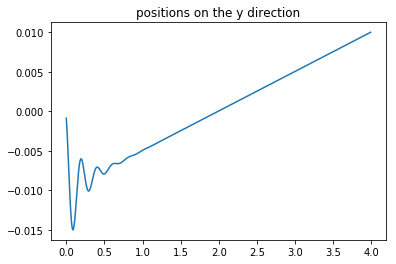

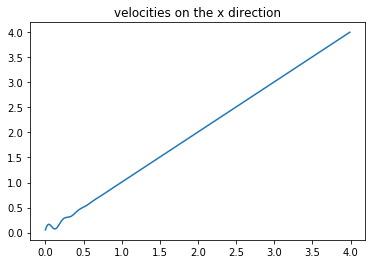

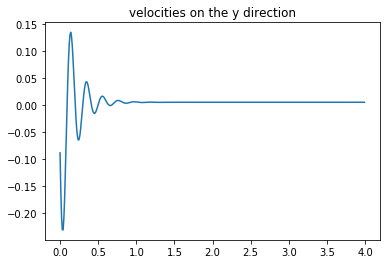

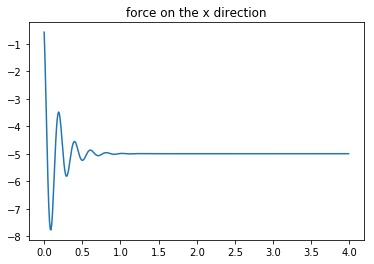

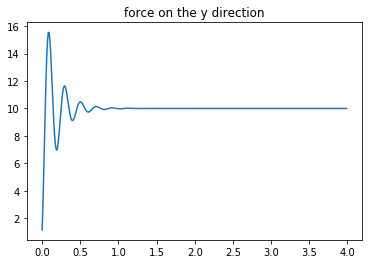

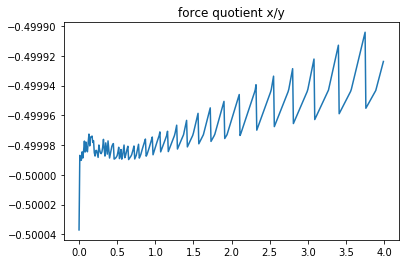

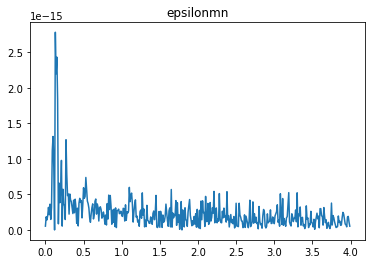

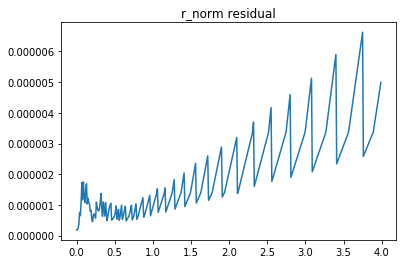

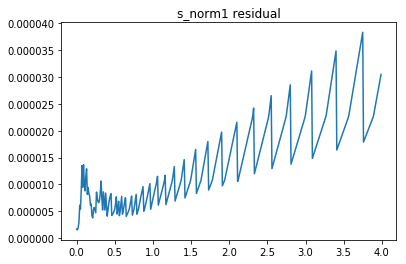

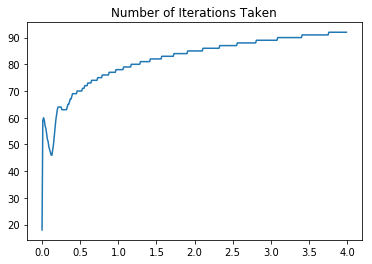

x force at time end:
-0.0499933141626
y force at time end:
0.100000301252
velovity at time 3 [ 3.00840615  0.00500325]
R [  0.01  10.  ]
-0.500037045366
92.0
0
0.5
lowest displacement on y:  -0.0150200067888


In [86]:
dropping_particle(4,0.01, 0, np.array([0,0]))

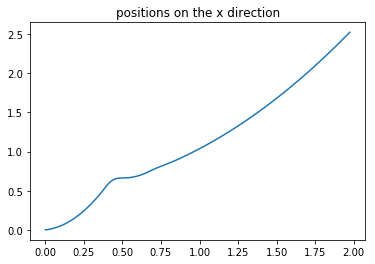

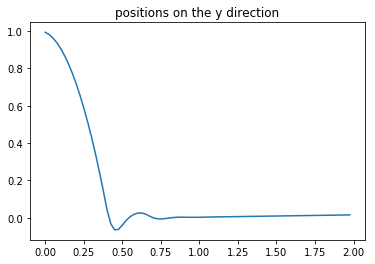

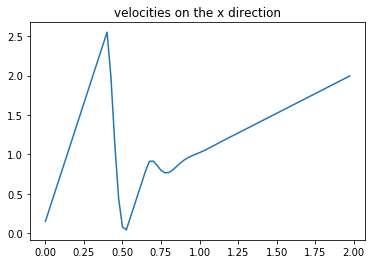

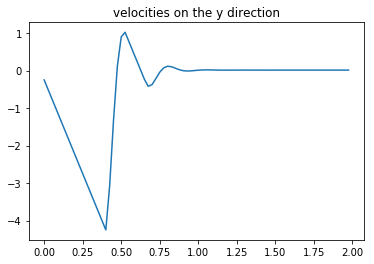

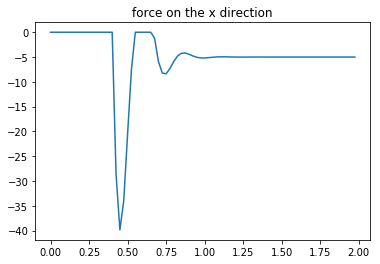

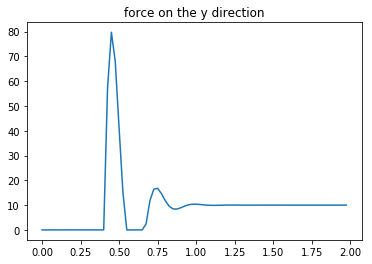

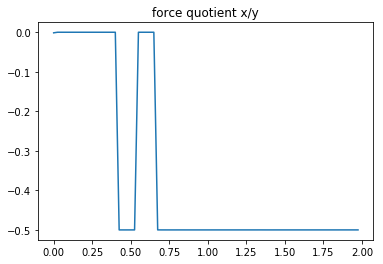

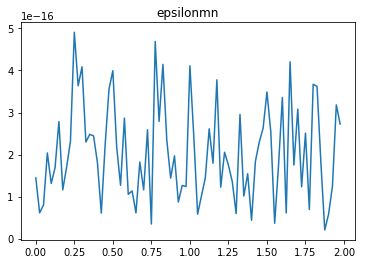

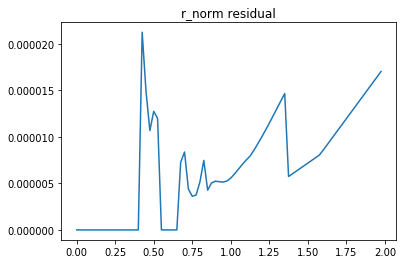

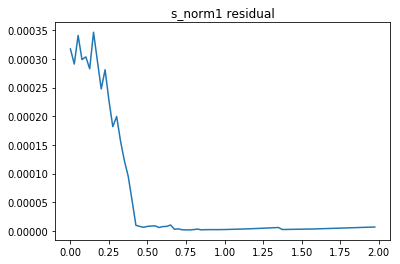

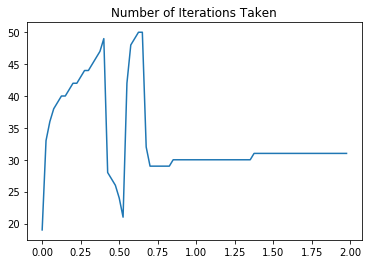

x force at time 0:
-2.90014952719e-07
y force at time 0:
0.000198478174822
-0.00146119316635
31.0
0
0.5
lowest displacement on y:  -0.0654817469248


In [46]:
dropping_particle(2,0.025, 0, np.array([0,1]))

25


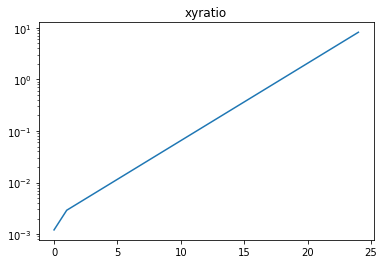

[  1.20433726e-03   2.89953056e-03   4.09698912e-03   5.78897842e-03
   8.17973155e-03   1.15578265e-02   1.63310193e-02   2.30754623e-02
   3.26052498e-02   4.60706831e-02   6.50971195e-02   9.19811620e-02
   1.29967873e-01   1.83642473e-01   2.59483802e-01   3.66646356e-01
   5.18065286e-01   7.32017752e-01   1.03432908e+00   1.46149002e+00
   2.06506142e+00   2.91789791e+00   4.12294189e+00   5.82564926e+00
   8.23154685e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


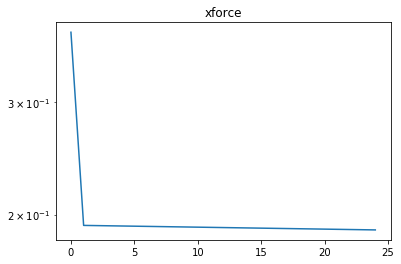

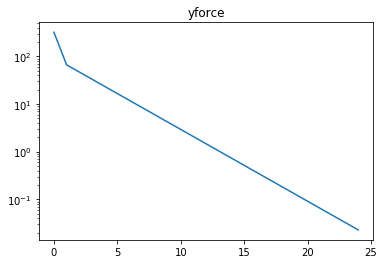

force final
[-0.18929423  0.02299619]
velocity starts dropping at time
0.0


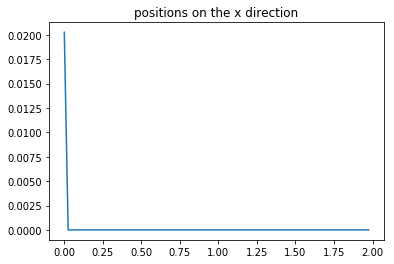

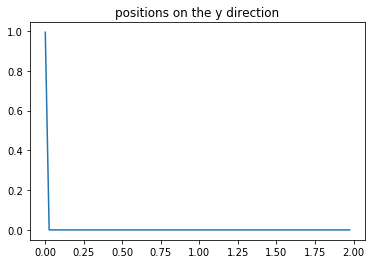

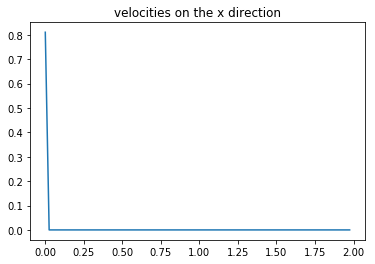

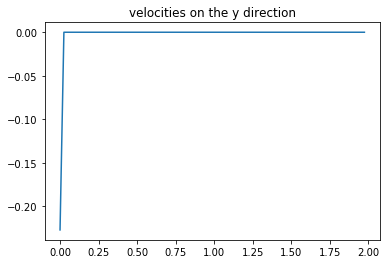

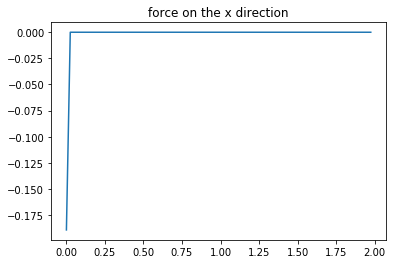

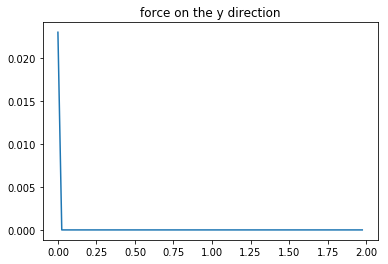

/usr/lib/python3/dist-packages/ipykernel_launcher.py:128: RuntimeWarning: invalid value encountered in true_divide


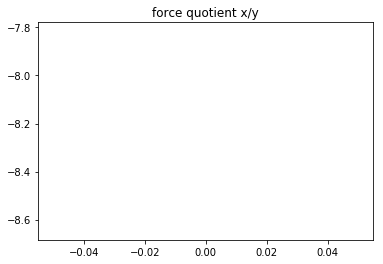

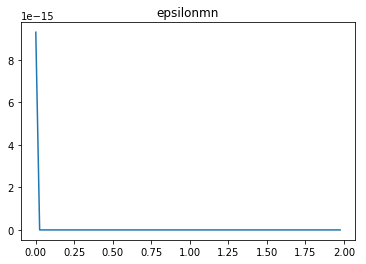

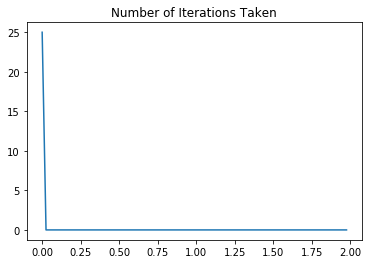

x force at time 0:
-0.189294233254
y force at time 0:
0.0229961921806
-8.23154684774
0.0
0.0316227766017
0.5


In [102]:
dropping_particle(2,0.025,1/(np.sqrt(1000)), np.array([0,1]), np.array([1,0]), True)

xyratio:
0.415118033551
mu
0.5
velocity starts dropping at time
0.0
xyratio:
0.358577912892
mu
0.5
xyratio:
0.267611923527
mu
0.5
xyratio:
0.202725443215
mu
0.5
xyratio:
0.159182822539
mu
0.5
xyratio:
0.127446188829
mu
0.5
xyratio:
0.102824756148
mu
0.5
xyratio:
0.0830180135017
mu
0.5
xyratio:
0.0669401925106
mu
0.5
xyratio:
0.0538983280913
mu
0.5
xyratio:
0.0433544850724
mu
0.5
xyratio:
0.0348542054724
mu
0.5
xyratio:
0.0278982853917
mu
0.5
xyratio:
0.0224189485149
mu
0.5
xyratio:
0.0180173610289
mu
0.5
xyratio:
0.0144812459318
mu
0.5
xyratio:
0.0115224725456
mu
0.5
xyratio:
0.00926575013437
mu
0.5
xyratio:
0.00745753718543
mu
0.5
xyratio:
0.00600642762619
mu
0.5
xyratio:
0.00472144893331
mu
0.5
xyratio:
0.0038092708861
mu
0.5
xyratio:
0.00308137069263
mu
0.5
xyratio:
0.00249808727511
mu
0.5
xyratio:
0.00203141265578
mu
0.5
xyratio:
0.00153911981272
mu
0.5
xyratio:
0.00126077952169
mu
0.5
xyratio:
0.00103993577704
mu
0.5
xyratio:
0.000377127443976
mu
0.5
velocity drop to 0 at time
1.4

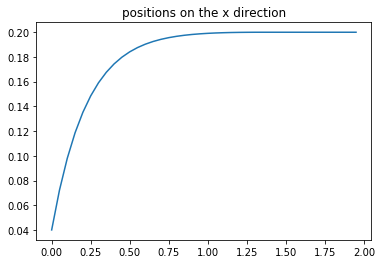

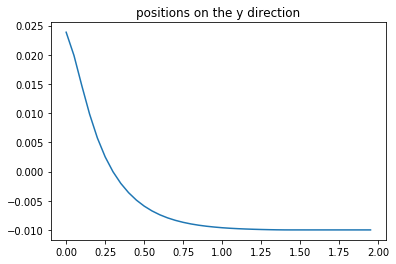

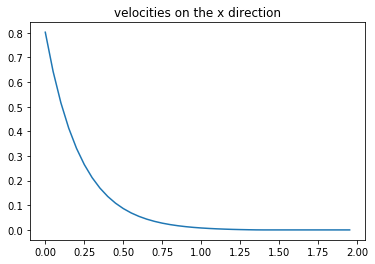

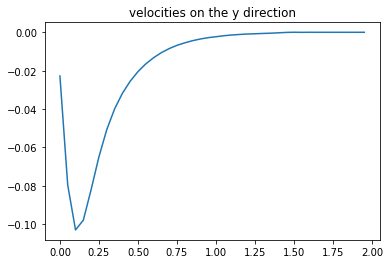

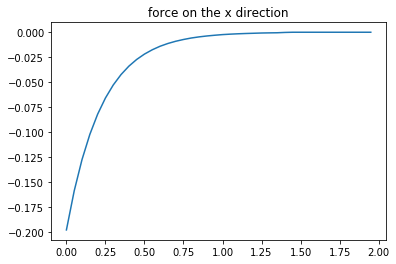

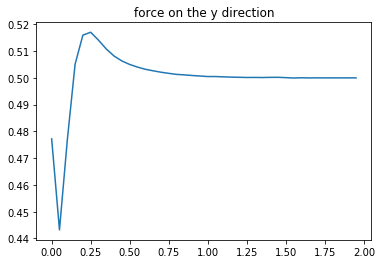

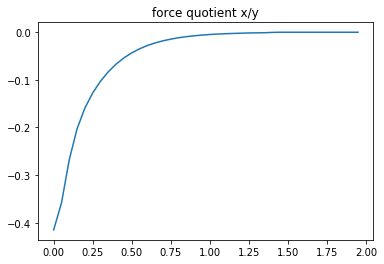

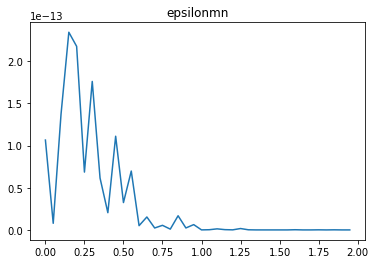

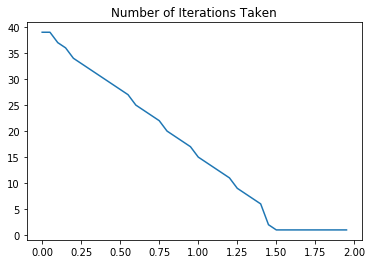

x force at time 0:
-0.1981008586
y force at time 0:
0.477215737668
-0.415118033551
1.0
0.0316227766017
0.5


In [41]:
dropping_particle(2,0.05,1/(np.sqrt(1000)), np.array([0,0.025]), np.array([1,0]))

xyratio:
0.0
mu
0.5
velocity drop to 0 at time
0.0
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:
0.0
mu
0.5
xyratio:


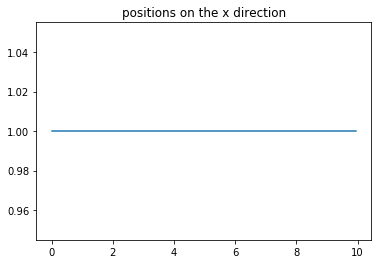

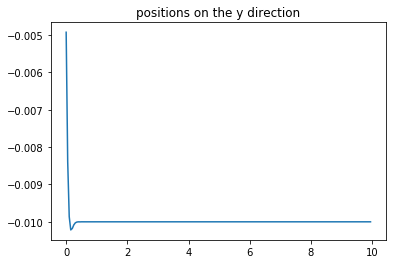

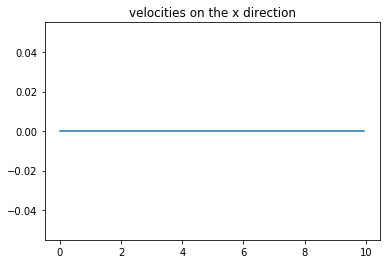

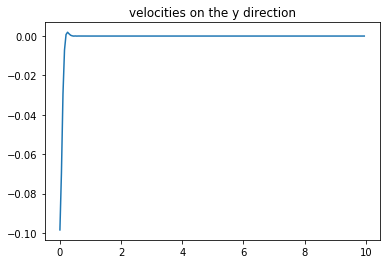

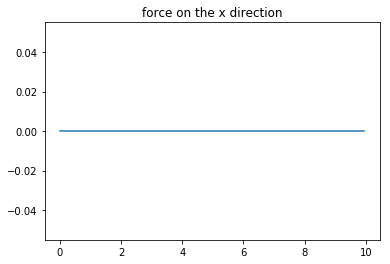

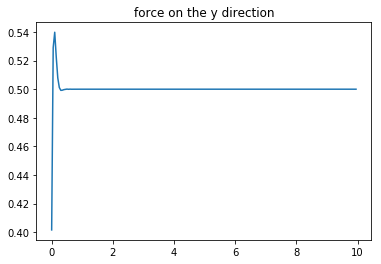

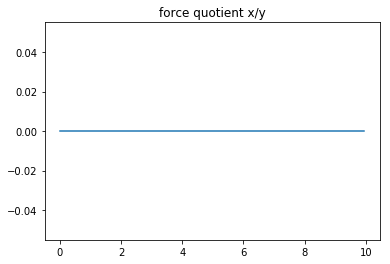

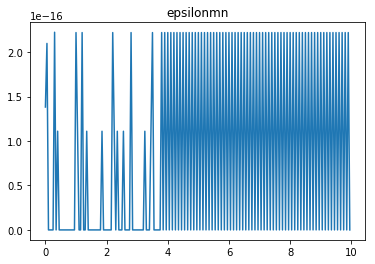

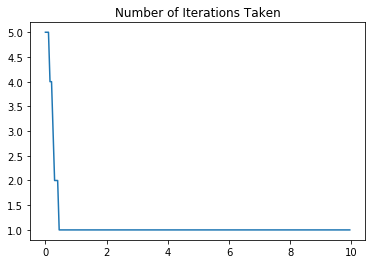

x force at time 0:
0.0
y force at time 0:
0.401548572134
0.0
1.0
0.0316227766017
0.5


In [42]:
dropping_particle(10,0.05,1/(np.sqrt(1000)))

velocity drop to 0 at time
0.0


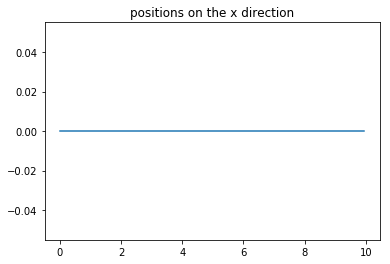

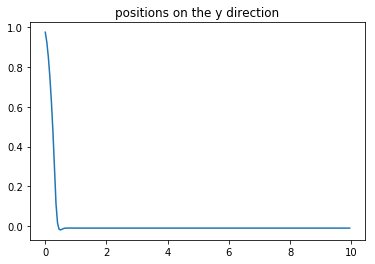

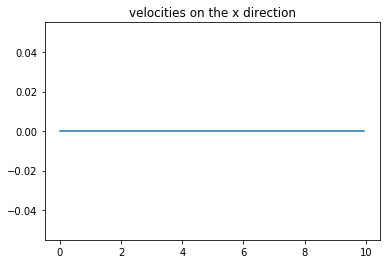

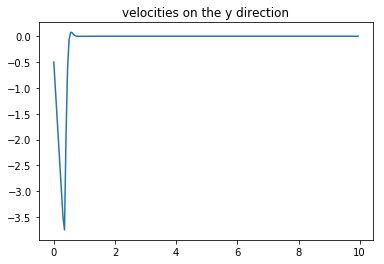

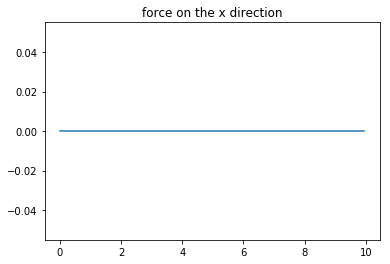

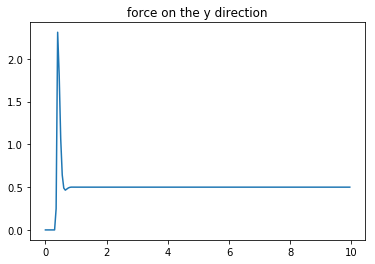

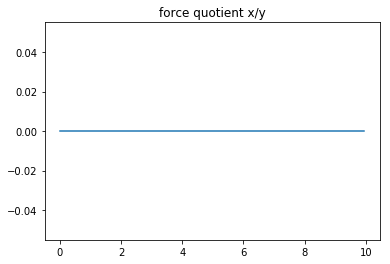

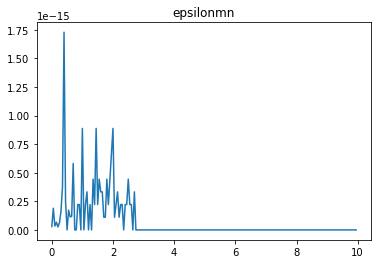

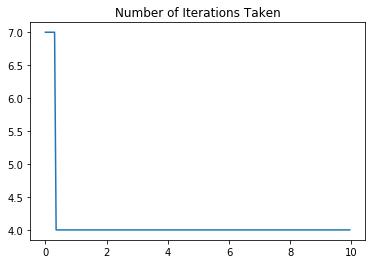

4.0
0.0316227766017
0.5


In [58]:
dropping_particle(10,0.05,1/(np.sqrt(1000)), np.array([0,1]), np.array([0,0]))

In [49]:
#2d projection test:

#t = np.linspace(-5,5, 0.1)
x = np.array([1,0])
v = projection_2D(x, 0.5)
print(v)


[ 0.2  0.4]


In [2]:
import numpy as np
print(1/np.identity(2))

[[  1.  inf]
 [ inf   1.]]


/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [7]:
print(diag(np.identity(2)))

[ 1.  1.]
